In [75]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

raw_train = train.copy()
raw_test = test.copy()

In [76]:
train.shape, test.shape

((1460, 81), (1459, 80))

- id drop

In [77]:
train.drop('Id',axis=1,inplace=True)
test.drop('Id',axis=1,inplace=True)
train.shape, test.shape

((1460, 80), (1459, 79))

- y normalization

In [78]:
from scipy import stats
from scipy.stats import norm, skew

C:\Users\admin\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

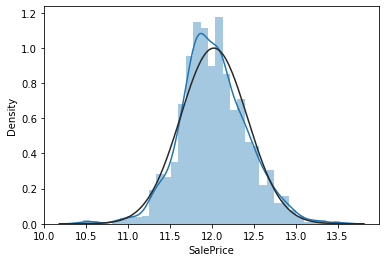

In [79]:
train['SalePrice'] = np.log1p(train['SalePrice'])
sns.distplot(train['SalePrice'],fit=norm)

- remove outliers 

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

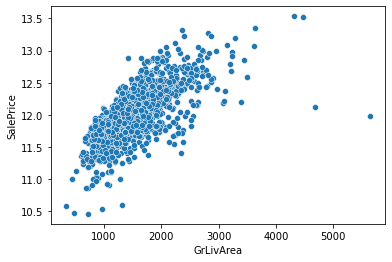

In [80]:
sns.scatterplot(data=train,x='GrLivArea',y='SalePrice')

In [81]:
train.shape

(1460, 80)

In [82]:
#train.drop(train[(train['OverallQual']<5) & (train['SalePrice']>200000)].index, inplace=True)
train.drop(train[(train['GrLivArea']>4500)].index, inplace=True)

In [83]:
train.shape

(1458, 80)

- concat train,test

In [84]:
all_data = pd.concat([train,test],ignore_index=True)
all_data.drop('SalePrice',axis=1,inplace=True)
all_data.shape

(2917, 79)

- num_actuallycat_feats convert to cat

In [85]:
all_data['MSSubClass'] = all_data['MSSubClass'].astype(str)
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

- divide numeric vs categoric

In [86]:
num_feats = all_data.select_dtypes(exclude='object').columns
cat_feats = all_data.select_dtypes(include='object').columns

- impute missings by each feats

In [87]:
all_data[num_feats].isnull().sum().sum(), all_data[cat_feats].isnull().sum().sum()

(678, 13280)

In [88]:
all_data[num_feats] = all_data[num_feats].fillna(all_data[num_feats].median())
for feat in cat_feats:
    all_data[feat] = all_data[feat].fillna(all_data[feat].mode()[0])

In [89]:
all_data[num_feats].isnull().sum().sum(), all_data[cat_feats].isnull().sum().sum()

(0, 0)

- normalize skewed numeric feats

In [90]:
skewness = all_data[num_feats].skew()
skewed_feats = skewness[skewness > 0.5].index
for feat in skewed_feats:
    all_data[feat] = np.log1p(all_data[feat])

- creating a few features based on intuition(six senses)

- get_dummies cat_feats

In [91]:
all_data.shape

(2917, 79)

In [92]:
all_data = pd.get_dummies(all_data)
all_data.shape

(2917, 317)

# Modeling

In [93]:
# Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.svm import SVR
from mlxtend.regressor import StackingCVRegressor
import lightgbm as lgb
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# Misc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

In [94]:
x = all_data.iloc[:train.shape[0],:]
y = train['SalePrice']
test = all_data.iloc[train.shape[0]:,:]

- Setup cross validation and define error metrics

In [206]:
kf = KFold(n_splits=12, random_state=42, shuffle=True)
def rmse_cv(model):
    scores = np.sqrt( -cross_val_score(model,x,y,scoring='neg_mean_squared_error',cv=kf) )
    return scores

- Setup models

In [207]:
# Light Gradient Boosting Regressor
lightgbm = LGBMRegressor(objective='regression', 
                       num_leaves=6,
                       learning_rate=0.01, 
                       n_estimators=7000,
                       max_bin=200, 
                       bagging_fraction=0.8,
                       bagging_freq=4, 
                       bagging_seed=8,
                       feature_fraction=0.2,
                       feature_fraction_seed=8,
                       min_sum_hessian_in_leaf = 11,
                       verbose=-1,
                       random_state=42)

# XGBoost Regressor
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=6000,
                       max_depth=4,
                       min_child_weight=0,
                       gamma=0.6,
                       subsample=0.7,
                       colsample_bytree=0.7,
                       objective='reg:linear',
                       nthread=-1,
                       scale_pos_weight=1,
                       seed=27,
                       reg_alpha=0.00006,
                       random_state=42)

# Ridge Regressor
ridge_alphas = [1e-15, 1e-10, 1e-8, 9e-4, 7e-4, 5e-4, 3e-4, 1e-4, 1e-3, 5e-2, 1e-2, 0.1, 0.3, 1, 3, 5, 10, 15, 18, 20, 30, 50, 75, 100]
ridge = make_pipeline(RobustScaler(), RidgeCV(alphas=ridge_alphas, cv=kf))

# Support Vector Regressor
svr = make_pipeline(RobustScaler(), SVR(C= 20, epsilon= 0.008, gamma=0.0003))

# Gradient Boosting Regressor
gbr = GradientBoostingRegressor(n_estimators=6000,
                                learning_rate=0.01,
                                max_depth=4,
                                max_features='sqrt',
                                min_samples_leaf=15,
                                min_samples_split=10,
                                loss='huber',
                                random_state=42)  

# Random Forest Regressor
rf = RandomForestRegressor(n_estimators=1200,
                          max_depth=15,
                          min_samples_split=5,
                          min_samples_leaf=5,
                          max_features=None,
                          oob_score=True,
                          random_state=42)

# Stack up all the models above, optimized using xgboost
stack_gen = StackingCVRegressor(regressors=(xgboost, lightgbm, svr, ridge, gbr, rf),
                                meta_regressor=xgboost,
                                use_features_in_secondary=True)

In [209]:
models = [lightgbm,xgboost,ridge,svr,gbr,rf,stack_gen]

- Train models
- Get cross validation scores for each model

In [98]:
model_names = ['lightgbm','xgboost','ridge','svr','gbr','rf']
model_scores = []
models.remove(stack_gen)
for model in models:
    model_scores.append( rmse_cv(model).mean() )
models.append(stack_gen)

In [99]:
model_scores

[0.13728841746081888,
 0.14393069433030847,
 0.12416930194108321,
 0.28595363192203305,
 0.129484698689748,
 0.14392225216087887]

In [163]:
model_names

['lightgbm', 'xgboost', 'ridge', 'svr', 'gbr', 'rf']

In [166]:
#model_info = pd.DataFrame(index=model_names,data=model_scores,columns=['Score'])
model_info = pd.concat([pd.Series(model_names), pd.Series(model_scores)],axis=1,keys=['Model','Score'])
model_info.sort_values(by='Score')

,Model,Score
2,ridge,0.124169
4,gbr,0.129485
0,lightgbm,0.137288
5,rf,0.143922
1,xgboost,0.143931
3,svr,0.285954


In [210]:
models.remove(stack_gen)
for model in models:
    model.fit(x,y)
models.append(stack_gen)

stack_gen.fit(np.array(x),np.array(y))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] min_sum_hessian_in_leaf is set=11, min_child_weight=0.001 will be ignored. Current value: min_sum_hessian_in_leaf=11
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[15:47:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:50:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[15:51:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/objective/regression_obj.cu:170: reg:linear is now deprecated in favor of 

StackingCVRegressor(meta_regressor=XGBRegressor(base_score=0.5,
                                                booster='gbtree',
                                                colsample_bylevel=1,
                                                colsample_bynode=1,
                                                colsample_bytree=0.7, gamma=0.6,
                                                gpu_id=-1,
                                                importance_type='gain',
                                                interaction_constraints='',
                                                learning_rate=0.01,
                                                max_delta_step=0, max_depth=4,
                                                min_child_weight=0, missing=nan,
                                                monotone_constraints='()',
                                                n_estimators=6000, n_jobs=8,
                                                nthread=...
     

In [110]:
def rmse(y_true,y_pred):
    return np.sqrt( mean_squared_error(y_true,y_pred) )

In [211]:
def blended_pred(x):
    return ((0.1 * ridge.predict(x)) + 
            (0.2 * svr.predict(x)) +
            (0.1 * gbr.predict(x)) + 
            (0.1 * xgboost.predict(x)) + 
            (0.1 * lightgbm.predict(x)) + 
            (0.05 * rf.predict(x)) + 
            (0.35 * stack_gen.predict(np.array(x))))

In [167]:
blended_score = rmse(y, blended_pred(x) )
blended_score

0.0716565599564008

In [197]:
#model_info.loc[6] = ['blended',blended_score]
model_info = model_info.append({'Model':'blended','Score':blended_score},ignore_index=True)
model_info.sort_values(by='Score')

,Model,Score
6,blended,0.071657
2,ridge,0.124169
4,gbr,0.129485
0,lightgbm,0.137288
5,rf,0.143922
1,xgboost,0.143931
3,svr,0.285954


In [212]:
submission = pd.read_csv('sample_submission.csv')
submission['SalePrice'] = np.expm1( blended_pred(test) )
submission.to_csv('submission_blended_hyperModels.csv',index=False)